# Template Matching

Essentially, this method takes a “sliding window” of our waldo query image and slides it across our puzzle image from left to right and top to bottom, one pixel at a time. Then, for each of these locations, we compute the correlation coefficient to determine how “good” or “bad” the match is. Regions with sufficiently high correlation can be considered “matches” for our waldo template.

In [1]:
# Finding Waldo

import cv2
import numpy as np

# Load input image and convert to grayscale
image = cv2.imread('images/WaldoBeach.jpg')
cv2.imshow('Where is Waldo?', image)
cv2.waitKey(0)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Load Template image
template = cv2.imread('images/waldo.jpg',0)
cv2.imshow('Waldo', template)
cv2.waitKey(0)
print(template.shape)

# cv2.matchTemplate(target_image, template_image, method)
result = cv2.matchTemplate(gray, template, cv2.TM_CCOEFF)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
print(min_val, max_val, min_loc, max_loc)  # max_loc corresponds to max_value

# Create Bounding Box
top_left = max_loc
bottom_right = (top_left[0]+template.shape[0], top_left[1]+template.shape[1])
cv2.rectangle(image, top_left, bottom_right, (0, 0, 255), 3)

cv2.imshow('Where is Waldo?', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

(49, 49)
-2278836.0 7682601.5 (40, 389) (484, 262)


In [2]:
# Drawbacks - Ineffective in cases of:
#     - Rotation
#     - Scaling (enlarging or shrinking)
#     - Photometric Changes (brightness, contrast, hue)
#     - Distortions (Affine)

# Corner Detection

In [3]:
# Corner Matching is tolerant of-
# - Rotation
# - Translations
# - Slight Photometric Changes (brightness, contrast, hue)

# Corner Matching is intolerant of-
# - Larger Photometric Changes (brightness, contrast, hue)
# - Scaling (enlarging or shrinking)

## Harris Corner Detection

In [4]:
import cv2
import numpy as np

# Load image then grayscale
image = cv2.imread('images/chess.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# The cornerHarris function requires the array datatype to be float32
gray = np.float32(gray)

harris_corners = cv2.cornerHarris(gray, 3, 3, 0.05)

#We use dilation of the corner points to enlarge them\
kernel = np.ones((7, 7), np.uint8)
harris_corners = cv2.dilate(harris_corners, kernel, iterations=2)

# Threshold for an optimal value, it may vary depending on the image.
image[harris_corners > 0.025 * harris_corners.max()] = [255, 127, 127]

cv2.imshow('Harris Corners', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Shi-Tomasi Corner Detection

In [5]:
import cv2
import numpy as np

img = cv2.imread('images/chess.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# We specific the top 50 corners
corners = cv2.goodFeaturesToTrack(gray, 49, 0.01, 15)

for corner in corners:
    x, y = corner[0]
    x = int(x)
    y = int(y)
    cv2.rectangle(img, (x-10, y-10), (x+10, y+10), (0, 255, 0), 2)
    
cv2.imshow("Corners Found", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Feature Detection

One important thing to understand is that after extracting the keypoints, you only obtain information about their position, and sometimes their coverage area (usually approximated by a circle or ellipse) in the image. While the information about keypoint position might sometimes be useful, it does not say much about the keypoints themselves.

Depending on the algorithm used to extract keypoint (SIFT, Harris corners, MSER), you will know some general characteristics of the extracted keypoints (e.g. they are centered around blobs, edges, prominent corners...) but you will not know how different or similar one keypoint is to the other.

Here's two simple examples where only the position and keypoint area will not help us:

=> If you have an image A (of a bear on a white background), and another image B, exact copy of A but translated for a few pixels: the extracted keypoints will be the same (on the same part of that bear). Those two images should be recognized as same, or similar. But, if the only information we have is their position, and that changed because of the translation, you can not compare the images.

=> If you have an image A (let's say, of a duck this time), and another image B, exactly the same duck as in A except twice the size: the extracted keypoints will be the same (same parts of the duck). Those are also same (similar) images. But all their sizes (areas) will be different: all the keypoints from the image B will be twice the size of those from image A.

So, here come descriptors: they are the way to compare the keypoints. They summarize, in vector format (of constant length) some characteristics about the keypoints. For example, it could be their intensity in the direction of their most pronounced orientation. It's assigning a numerical description to the area of the image the keypoint refers to.

Some important things for descriptors are:
a) they should be independent of keypoint position
=> If the same keypoint is extracted at different positions (e.g. because of translation) the descriptor should be the same.

b) they should be robust against image transformations
=> Some examples are changes of contrast (e.g. image of the same place during a sunny and cloudy day) and changes of perspective (image of a building from center-right and center-left, we would still like to recognize it as a same building).

Of course, no descriptor is completely robust against all transformations (nor against any single one if it is strong, e.g. big change in perspective). Different descriptors are designed to be robust against different transformations which is sometimes opposed to the speed it takes to calculate them.

c) they should be scale independent
=> The descriptors should take scale in to account. If the "prominent" part of the one keypoint is a vertical line of 10px (inside a circular area with radius of 8px), and the prominent part of another a vertical line of 5px (inside a circular area with radius of 4px) -- these keypoints should be assigned similar descriptors.

Now, that you calculated descriptors for all the keypoinst, you have a way to compare those keypoints. For a simple example of image matching (when you know the images are of the same object, and would like to identify the parts in different images that depict the same part of the scene, or would like to identify the perspective change between two images), you would compare every keypoint descriptor of one image to every keypoint descriptor of the other image. As the descriptors are vectors of numbers, you can compare them with something as simple as Euclidian distance. There are some more complex distances that can be used as a similarity measure, of course. But, in the end, you would say that the keypoints whose descriptors have the smallest distance between them are matches, e.g. same "places" or "parts of objects" in different images.

## SIFT (Scale-Invariant Feature Transform)

In [6]:
# Steps-
# 1. Scale-space Extrema Detection => search for stable features across multiple scales
# 2. Keypoint Localization => Fit a model to detrmine location & scale. Select keypoints based on a measure of stability.
# 3. Orientation Assignment => Compute best orientation(s) for each keypoint region.
# 4. Keypoint Descriptor => Use local image gradients at selected scale and rotation to describe each keypoint region.
# 5. Keypoint Matching

In [7]:
# import cv2
# import numpy as np

# image = cv2.imread('images/input.jpg')
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Create SIFT Feature Detector object
# sift = cv2.SIFT() 

# # Detect key points
# keypoints = sift.detect(gray, None)
# print("Number of keypoints Detected: ", len(keypoints))

# # Draw rich key points on input image
# image = cv2.drawKeypoints(image, keypoints, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# cv2.imshow('Feature Method - SIFT', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

## Has removed from OpenCV

## SURF (Speeded-Up Robust Features)

In [8]:
# import cv2
# import numpy as np

# image = cv2.imread('images/input.jpg')
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Create SURF Feature Detector object
# surf = cv2.SURF()

# # Only features, whose hessian is larger than hessianThreshold are retained by the detector
# surf.hessianThreshold = 500
# keypoints, descriptors = surf.detectAndCompute(gray, None)
# print("Number of keypoints Detected: ", len(keypoints))

# # Draw rich key points on input image
# image = cv2.drawKeypoints(image, keypoints, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# cv2.imshow('Feature Method - SURF', image)
# cv2.waitKey()
# cv2.destroyAllWindows()

## Has removed from OpenCV

## FAST (Features from Accelerated Segment Test)

In [9]:
# It is several times faster than other existing corner detectors.
# But it is not robust to high levels of noise. It is dependant on a threshold.

In [10]:
# import cv2
# import numpy as np

# image = cv2.imread('images/input.jpg')
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Create FAST Detector object
# fast = cv2.FastFeatureDetector()

# # Obtain Key points, by default non max suppression is On
# # to turn off set fast.setBool('nonmaxSuppression', False)
# keypoints = fast.detect(gray, None)
# print("Number of keypoints Detected: ", len(keypoints))

# # Draw rich keypoints on input image
# image = cv2.drawKeypoints(image, keypoints, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# cv2.imshow('Feature Method - FAST', image)
# cv2.waitKey()
# cv2.destroyAllWindows()

## Has removed from OpenCV

## BRIEF (Binary Robust Independent Elementary Features)

In [11]:
# import cv2
# import numpy as np

# image = cv2.imread('images/input.jpg')
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Create FAST detector object
# star = cv2.FeatureDetector_create("STAR")

# # Create BRIEF extractor object
# brief = cv2.DescriptorExtractor_create("BRIEF")

# # Determine key points
# keypoints = star.detect(gray, None)

# # Obtain descriptors and new final keypoints using BRIEF
# keypoints, descriptors = brief.compute(gray, keypoints)
# print("Number of keypoints Detected: ", len(keypoints))

# # Draw rich keypoints on input image
# image = cv2.drawKeypoints(image, keypoints, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                                    
# cv2.imshow('Feature Method - BRIEF', image)
# cv2.waitKey()
# cv2.destroyAllWindows()

## Has removed from OpenCV

## ORB (Oriented FAST and Rotated BRIEF)

In [12]:
import cv2
import numpy as np

image = cv2.imread('images/input.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Create ORB object, we can specify the number of key points we desire
orb = cv2.ORB_create(10)

# Determine key points
keypoints, descriptors = orb.detectAndCompute(gray, None)

# Obtain the descriptors
#keypoints, descriptors = orb.compute(gray, keypoints)
print("Number of keypoints Detected: ", len(keypoints))

# Draw rich keypoints on input image
image = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imshow('Feature Method - ORB', image)
cv2.waitKey()
cv2.destroyAllWindows()

Number of keypoints Detected:  10


# Object Detection & Matching

BFMatcher is going to try all the possibilities (which is the meaning of "Brute Force") and hence it will find the best matches.

FLANN, meaning "Fast Library for Approximate Nearest Neighbors", will be much faster but will find an approximate nearest neighbors. It will find a good matching, but not necessarily the best possible one. You can play with FLANN's parameters in order to increase the precision (i.e. the "quality" of the matchings), but it will be at the cost of slowing the algorithm.

In [13]:
import cv2
import numpy as np


def ORB_detector(new_image, image_template):
    # Function that compares input image to template
    # It then returns the number of ORB matches between them
    
    image1 = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)

    # Create ORB detector with 1000 keypoints with a scaling pyramid factor of 1.2
    orb = cv2.ORB_create(1000, 1.2)

    # Detect keypoints of original image
    (kp1, des1) = orb.detectAndCompute(image1, None)

    # Detect keypoints of rotated image
    (kp2, des2) = orb.detectAndCompute(image_template, None)

    # Create matcher 
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Do matching
    matches = bf.match(des1, des2)

    # Sort the matches based on distance. (Least distance is better)
    matches = sorted(matches, key=lambda val: val.distance)

    return len(matches)
    
#     # Define parameters for our Flann Matcher
#     FLANN_INDEX_KDTREE = 0
#     index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)
#     search_params = dict(checks = 100)

#     # Create the Flann Matcher object
#     flann = cv2.FlannBasedMatcher(index_params, search_params)

#     # Obtain matches using K-Nearest Neighbor Method
#     # the result 'matchs' is the number of similar matches found in both images
#     matches = flann.knnMatch(des1, des1, k=2)

#     # Store good matches using Lowe's ratio test
#     good_matches = []
#     for m,n in matches:
#         if m.distance < 0.7 * n.distance:
#             good_matches.append(m) 

#     return len(good_matches)

# Video Capturing
cap = cv2.VideoCapture(0)

# Load our image template, this is our reference image
image_template = cv2.imread('images/Rohit_Photo.jpg', 0)
cv2.imshow('Template', image_template)

while True:
    # Get webcam images
    ret, frame = cap.read()

    # Get height and width of webcam frame
    height, width = frame.shape[:2]

    # Define ROI Box Dimensions (Note some of these things should be outside the loop)
    top_left_x = int(width / 3)
    top_left_y = int((height / 2) + (height / 4))
    bottom_right_x = int((width / 3) * 2)
    bottom_right_y = int((height / 2) - (height / 4))
    
    # Draw rectangular window for our region of interest
    cv2.rectangle(frame, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (255, 0, 0), 3)
    
    # Crop window of observation we defined above
    cropped = frame[bottom_right_y:top_left_y, top_left_x:bottom_right_x]

    # Flip frame orientation horizontally
    frame = cv2.flip(frame, 1)
    
    # Get number of ORB matches 
    matches = ORB_detector(cropped, image_template)
    
    # Display status string showing the current no. of matches 
    output_string = "Matches = " + str(matches)
    cv2.putText(frame, output_string, (50, 450), cv2.FONT_HERSHEY_COMPLEX, 2, (250, 0, 150), 2)
    
    # Our threshold to indicate object deteciton
    # For new images or lightening conditions we may need to experiment a bit 
    # Note: The ORB detector to get the top 1000 matches, 350 is essentially a min 35% match
    threshold = 80
    
    # If matches exceed our threshold then object has been detected
    if matches > threshold:
        cv2.rectangle(frame, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (0, 255, 0), 3)
        cv2.putText(frame, 'Found', (210, 50), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 255, 0), 2)
    
    cv2.imshow('Object Detector using ORB', frame)
    
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break

cap.release()
cv2.destroyAllWindows()

The above implementation has very low accuracy wrt. face detection & is not the best way!

# Histogram of Oriented Gradients (HoG)

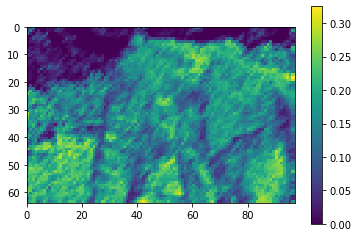

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load image then grayscale
image = cv2.imread('images/elephant.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Show original Image
cv2.imshow('Input Image', image)
cv2.waitKey(0)

# h x w in pixels
cell_size = (8, 8) 

 # h x w in cells
block_size = (2, 2) 

# number of orientation bins
nbins = 9

# Using OpenCV's HOG Descriptor
# winSize is the size of the image cropped to a multiple of the cell size
hog = cv2.HOGDescriptor(_winSize=(gray.shape[1] // cell_size[1] * cell_size[1],
                                  gray.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

# Create numpy array shape which we use to create hog_feats
n_cells = (gray.shape[0] // cell_size[0], gray.shape[1] // cell_size[1])

# We index blocks by rows first.
# hog_feats now contains the gradient amplitudes for each direction,
# for each cell of its group for each group. Indexing is by rows then columns.
hog_feats = hog.compute(gray).reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins).transpose((1, 0, 2, 3, 4))  

# Create our gradients array with nbin dimensions to store gradient orientations 
gradients = np.zeros((n_cells[0], n_cells[1], nbins))

# Create array of dimensions 
cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

# Block Normalization
for off_y in range(block_size[0]):
    for off_x in range(block_size[1]):
        gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                  off_x:n_cells[1] - block_size[1] + off_x + 1] += \
            hog_feats[:, :, off_y, off_x, :]
        cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                   off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

# Average gradients
gradients /= cell_count

# Plot HOGs using Matplotlib
# angle is 360 / nbins * direction
color_bins = 5
plt.pcolor(gradients[:, :, color_bins])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()
cv2.destroyAllWindows()

# Run this following block of code twice of the graphs to be displayed!